In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
from os import walk
from os.path import join

plt.style.use('seaborn')
%matplotlib inline

pbp_dir = 'Play By Play Data'
sv_dir = 'SportVu CSVs'

# Get a list of all the files in the top level of a directory
def fileList(directory):
    f = []
    for (dirpath, dirnames, filenames) in walk(directory):
        f.extend(filenames)
        break
    
    return f

# Merge data from a single game into a dataframe, keeping only rows that have matching event IDs
def mergeSVtoPBP(filename):
    sv = pd.read_csv(join(sv_dir, filename))
    pbp = pd.read_csv(join(pbp_dir, filename))
    pbp = pbp[['EVENTNUM', 'GAME_ID', 'EVENTMSGTYPE_DESCRIPTION', 'EVENTMSGACTIONTYPE_DESCRIPTION']]
    df = pd.merge(sv, pbp, how='inner', left_on = 'event.id', right_on = 'EVENTNUM')
    
    return df

# Compile all CSV files from a directory into a single dataframe
def dfFromDirectory(directory):
    pbplist = fileList(directory)
    pbp_df = pd.DataFrame()
    for f in pbplist:
        if f[-3:].upper() == 'CSV':
            df = pd.read_csv(join(directory, f))
            pbp_df = pbp_df.append(df, ignore_index=True)
        
    return pbp_df

# Filter the Play By Play dataframe by event. Context = True will include the 2 plays before and after the event
def filterByEvent(pbp_df, e1, e2 = -1, context = False):
    if e2 > -1:
        idx_list = pbp_df.index[(pbp_df['EVENTMSGTYPE'] == e1) & (pbp_df['EVENTMSGACTIONTYPE'] == e2)].tolist()
    else:
        idx_list = pbp_df.index[pbp_df['EVENTMSGTYPE'] == e1].tolist()
    if context:
        filter_idx = []
        for idx in idx_list:
            filter_idx.extend([idx-2, idx-1, idx, idx+1, idx+2])
    else:
        filter_idx = idx_list
    play_df = pbp_df.iloc[filter_idx]
    
    return play_df

In [2]:
pbp_df = dfFromDirectory(pbp_dir)

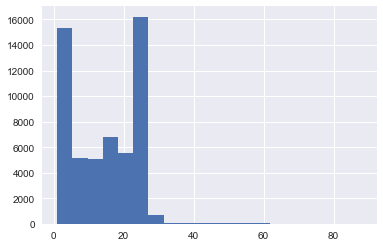

In [3]:
def shot_distance(row):
    if int(row['EVENTMSGTYPE']) == 2: # Missed Field Goal
        if int(row['PERSON1TYPE']) == 4: # Home team
            try:
                dist = int(re.findall("(\d+)\'", row['HOMEDESCRIPTION'])[0]) # Get all digits immediately preceding '
            except:
                dist = None
        if int(row['PERSON1TYPE']) == 5: # Visitor team
            try:
                dist = int(re.findall("(\d+)\'", row['VISITORDESCRIPTION'])[0]) # Get all digits immediately preceding '
            except:
                dist = None
        return dist
    
pbp_df['SHOT_DISTANCE'] = pbp_df.apply(lambda x: shot_distance(x), axis = 1)
pbp_df['SHOT_DISTANCE'].hist(bins = 20)

In [20]:
def getOnlyIfPreviousEvent(pbp_df, e1, e3, e2 = -1):
    if e2 > -1:
        idx_list = pbp_df.index[(pbp_df['EVENTMSGTYPE'] == e1) & (pbp_df['EVENTMSGACTIONTYPE'] == e2)].tolist()
    else:
        idx_list = pbp_df.index[pbp_df['EVENTMSGTYPE'] == e1].tolist()
        
    filter_idx = []
    for idx in idx_list:
        if pbp_df.iloc[idx-1]['EVENTMSGTYPE'] == e3:
            filter_idx.extend([idx])
        
    play_df = pbp_df.iloc[filter_idx]
    
    return play_df

all_reb_df = filterByEvent(pbp_df, 4, 0) # Get all player rebounds
missfg_reb_df = getOnlyIfPreviousEvent(pbp_df, e1 = 4, e2 = 0, e3 = 2) # Get player rebounds preceded by missed FG
print("{} total player rebounds".format(len(all_reb_df)))
print("{} total player rebounds immediately preceded by a missed field goal".format(len(missfg_reb_df)))

62253 total player rebounds
58531 total player rebounds immediately preceded by a missed field goal


In [31]:

def addBlock(row):
    prevrow = pbp_df.iloc[row.name-1]
    if (prevrow['EVENTMSGTYPE'] == 2) and (row['EVENTMSGTYPE'] == 4) and (row['EVENTMSGACTIONTYPE'] == 0): # If player rebound is preceded by missed FG
        if ('BLOCK' in str(prevrow['HOMEDESCRIPTION'])) or ('BLOCK' in str(prevrow['VISITORDESCRIPTION'])): # Same team shot and got the rebound
            return True
        else:
            return False
        
pbp_df['BLOCKED_SHOT'] = pbp_df.apply(lambda x: addBlock(x), axis = 1)

62253 total player rebounds
58531 total player rebounds immediately preceded by a missed field goal
False    52341
True      6190
Name: BLOCKED_SHOT, dtype: int64


In [38]:
print("{} total player rebounds".format(len(all_reb_df)))
print("{} total player rebounds immediately preceded by a missed field goal".format(len(missfg_reb_df)))
print("Of those {} rebounds, {} were from blocked shots, {} were not".format(
    len(missfg_reb_df),
    pbp_df['BLOCKED_SHOT'].value_counts()[True],
    pbp_df['BLOCKED_SHOT'].value_counts()[False]))

62253 total player rebounds
58531 total player rebounds immediately preceded by a missed field goal
Of those 58531 rebounds, 6190 were from blocked shots, 52341 were not


In [5]:
def addShotDistToRebounds(row):
    if row['SHOT_DISTANCE'] >= 0:
        return row['SHOT_DISTANCE']
    if pbp_df.iloc[row.name-1]['EVENTMSGTYPE'] == 2: # If previous event was a missed FG
        return pbp_df.iloc[row.name-1]['SHOT_DISTANCE']

pbp_df['SHOT_DISTANCE'] = pbp_df.apply(lambda x: addShotDistToRebounds(x), axis = 1)

In [6]:
def addOffensiveRebounds(row):
    prevrow = pbp_df.iloc[row.name-1]
    if (prevrow['EVENTMSGTYPE'] == 2) and (row['EVENTMSGTYPE'] == 4) and (row['EVENTMSGACTIONTYPE'] == 0): # If player rebound is preceded by missed FG
        if (((prevrow['PERSON1TYPE'] == 4) and (row['PERSON1TYPE'] == 4)) or
           ((prevrow['PERSON1TYPE'] == 5) and (row['PERSON1TYPE'] == 5))): # Same team shot and got the rebound
            return True
        else:
            return False
        
pbp_df['OFF_REB'] = pbp_df.apply(lambda x: addOffensiveRebounds(x), axis = 1)
pbp_df['OFF_REB'].value_counts()

False    45630
True     12901
Name: OFF_REB, dtype: int64

In [7]:
missfg_reb_df = getOnlyIfPreviousEvent(pbp_df, e1 = 4, e2 = 0, e3 = 2) # Get player rebounds preceded by missed FG
missfg_reb_df.head()

,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,...,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,EVENTMSGTYPE_DESCRIPTION,EVENTMSGACTIONTYPE_DESCRIPTION,SHOT_DISTANCE,OFF_REB
3,21500001,3,4,0,1,8:13 PM,11:39,Bazemore REBOUND (Off:0 Def:1),NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,Rebound,Player Rebound,2.0,False
9,21500001,9,4,0,1,8:14 PM,10:25,NaN,NaN,Jackson REBOUND (Off:0 Def:1),...,0,NaN,NaN,NaN,NaN,NaN,Rebound,Player Rebound,20.0,False
11,21500001,11,4,0,1,8:14 PM,10:11,Bazemore REBOUND (Off:0 Def:2),NaN,NaN,...,0,NaN,NaN,NaN,NaN,NaN,Rebound,Player Rebound,8.0,False
18,21500001,21,4,0,1,8:16 PM,9:28,NaN,NaN,Drummond REBOUND (Off:0 Def:1),...,0,NaN,NaN,NaN,NaN,NaN,Rebound,Player Rebound,15.0,False
21,21500001,24,4,0,1,8:16 PM,9:11,NaN,NaN,Drummond REBOUND (Off:0 Def:2),...,0,NaN,NaN,NaN,NaN,NaN,Rebound,Player Rebound,1.0,False
